## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp003'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

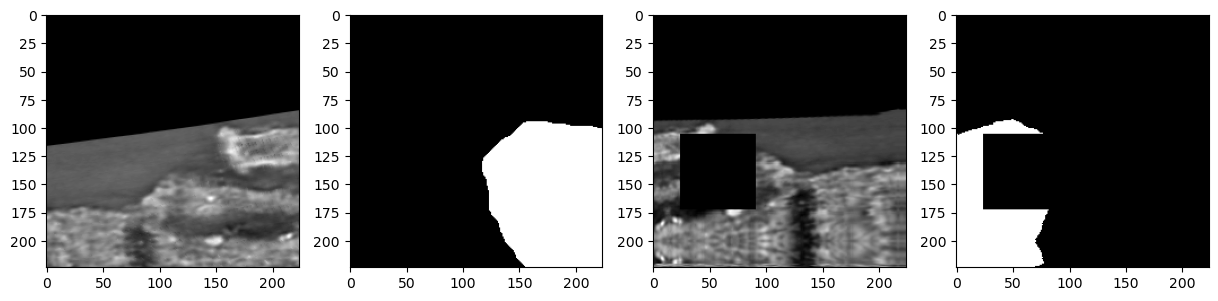

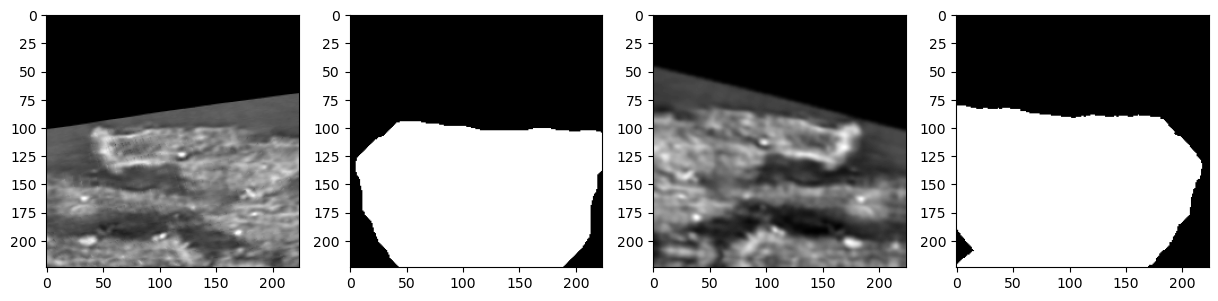

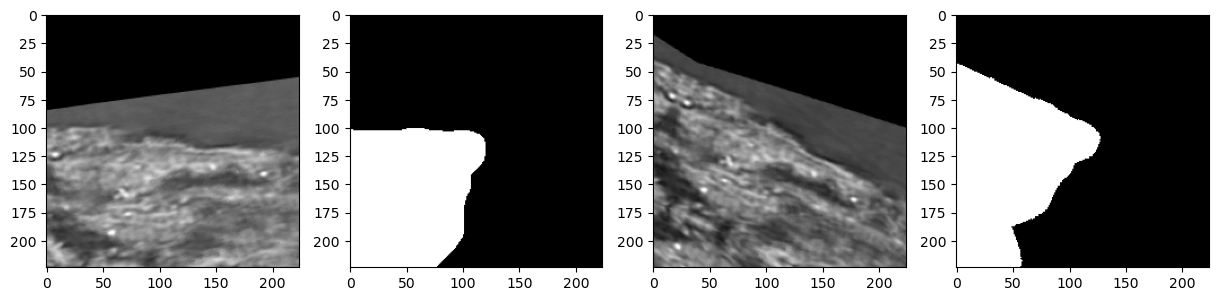

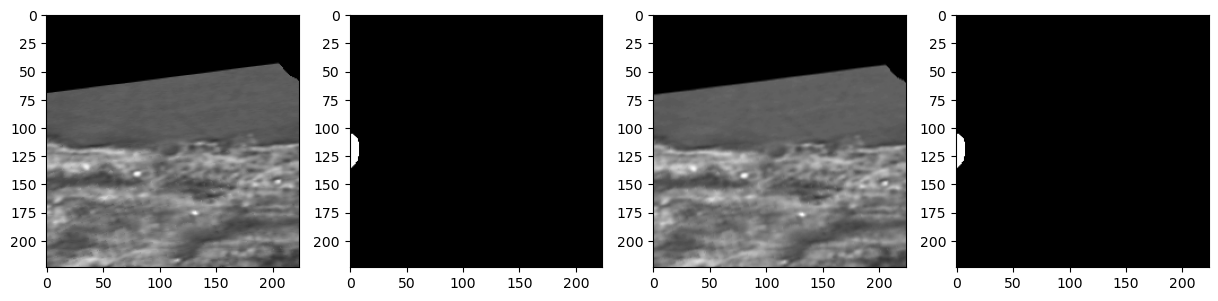

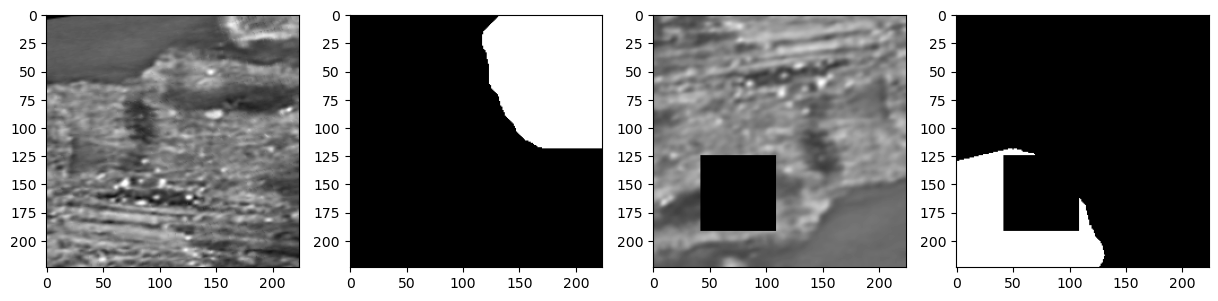

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48140

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501398283641252
th: 0.15, fbeta: 0.0950240464570309
th: 0.2, fbeta: 0.1371641925816959
th: 0.25, fbeta: 0.1650256201815554
th: 0.3, fbeta: 0.21994713153201847
th: 0.35, fbeta: 0.28226767029877686
th: 0.4, fbeta: 0.3334451520639284
th: 0.45, fbeta: 0.3682180613054732


best_th: 0.5, fbeta: 0.37854204432092997
Epoch 1 - avg_train_loss: 0.5458  avg_val_loss: 0.3805  time: 153s
Epoch 1 - avgScore: 0.3785
Epoch 1 - Save Best Score: 0.3785 Model
Epoch 1 - Save Best Loss: 0.3805 Model


th: 0.5, fbeta: 0.37854204432092997


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09503085934547396
th: 0.15, fbeta: 0.1461383899250808
th: 0.2, fbeta: 0.1810787125600675
th: 0.25, fbeta: 0.2739180333374601
th: 0.3, fbeta: 0.33816816802762995
th: 0.35, fbeta: 0.38049074854267434
th: 0.4, fbeta: 0.41738521839207937


best_th: 0.5, fbeta: 0.4781409510515206
Epoch 2 - avg_train_loss: 0.3732  avg_val_loss: 0.3089  time: 155s
Epoch 2 - avgScore: 0.4781
Epoch 2 - Save Best Score: 0.4781 Model
Epoch 2 - Save Best Loss: 0.3089 Model


th: 0.45, fbeta: 0.4503211969342888
th: 0.5, fbeta: 0.4781409510515206


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2533213154570288
th: 0.15, fbeta: 0.30591270118355457
th: 0.2, fbeta: 0.34339790414806826
th: 0.25, fbeta: 0.37613918888622755
th: 0.3, fbeta: 0.40453442138342316
th: 0.35, fbeta: 0.42729516197188216
th: 0.4, fbeta: 0.45006241975323713
th: 0.45, fbeta: 0.4766140258452268


best_th: 0.5, fbeta: 0.5053336638830126
Epoch 3 - avg_train_loss: 0.2805  avg_val_loss: 0.2065  time: 156s
Epoch 3 - avgScore: 0.5053
Epoch 3 - Save Best Score: 0.5053 Model
Epoch 3 - Save Best Loss: 0.2065 Model


th: 0.5, fbeta: 0.5053336638830126


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2102351356754452
th: 0.15, fbeta: 0.24557829457839106
th: 0.2, fbeta: 0.27668222832183514
th: 0.25, fbeta: 0.3094031038182955
th: 0.3, fbeta: 0.3465567920872334
th: 0.35, fbeta: 0.38373338784232175
th: 0.4, fbeta: 0.4239813010563241


best_th: 0.5, fbeta: 0.514165231992982
Epoch 4 - avg_train_loss: 0.2456  avg_val_loss: 0.2226  time: 154s
Epoch 4 - avgScore: 0.5142
Epoch 4 - Save Best Score: 0.5142 Model
Epoch 4 - Save Best Loss: 0.2226 Model


th: 0.45, fbeta: 0.46981317338987255
th: 0.5, fbeta: 0.514165231992982


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23406704252800078
th: 0.15, fbeta: 0.27324125358244106
th: 0.2, fbeta: 0.3141299818137216
th: 0.25, fbeta: 0.35608654047111443
th: 0.3, fbeta: 0.4001626516399221
th: 0.35, fbeta: 0.4404990843633856
th: 0.4, fbeta: 0.4798091542375338
th: 0.45, fbeta: 0.5166112084436478


best_th: 0.5, fbeta: 0.5459954033204816
Epoch 5 - avg_train_loss: 0.2288  avg_val_loss: 0.2022  time: 153s
Epoch 5 - avgScore: 0.5460
Epoch 5 - Save Best Score: 0.5460 Model
Epoch 5 - Save Best Loss: 0.2022 Model


th: 0.5, fbeta: 0.5459954033204816


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22281642841197116
th: 0.15, fbeta: 0.25807927863776525
th: 0.2, fbeta: 0.29467242387854187
th: 0.25, fbeta: 0.33049312776669537
th: 0.3, fbeta: 0.3672012151961342
th: 0.35, fbeta: 0.40742898696231633
th: 0.4, fbeta: 0.44524697844916294
th: 0.45, fbeta: 0.4810192884573028


best_th: 0.5, fbeta: 0.5168286498596268
Epoch 6 - avg_train_loss: 0.2185  avg_val_loss: 0.2164  time: 154s
Epoch 6 - avgScore: 0.5168


th: 0.5, fbeta: 0.5168286498596268


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3325281448485709
th: 0.15, fbeta: 0.40198328463501093
th: 0.2, fbeta: 0.4563305034258919
th: 0.25, fbeta: 0.502800428975167
th: 0.3, fbeta: 0.5391773257369415
th: 0.35, fbeta: 0.5641271728059859
th: 0.4, fbeta: 0.5848219853920735
th: 0.45, fbeta: 0.5936815530716384


best_th: 0.45, fbeta: 0.5936815530716384
Epoch 7 - avg_train_loss: 0.2063  avg_val_loss: 0.1858  time: 155s
Epoch 7 - avgScore: 0.5937
Epoch 7 - Save Best Score: 0.5937 Model
Epoch 7 - Save Best Loss: 0.1858 Model


th: 0.5, fbeta: 0.589598984232424


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26318983545982366
th: 0.15, fbeta: 0.3082773970807086
th: 0.2, fbeta: 0.3496997320934777
th: 0.25, fbeta: 0.3902121906645137
th: 0.3, fbeta: 0.4266984148444414
th: 0.35, fbeta: 0.4630833801200847
th: 0.4, fbeta: 0.4985987311687002
th: 0.45, fbeta: 0.5302801344962388


best_th: 0.5, fbeta: 0.5610878436044158
Epoch 8 - avg_train_loss: 0.1949  avg_val_loss: 0.1955  time: 155s
Epoch 8 - avgScore: 0.5611


th: 0.5, fbeta: 0.5610878436044158


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35748299621529683
th: 0.15, fbeta: 0.4104024924466071
th: 0.2, fbeta: 0.4525693706392528
th: 0.25, fbeta: 0.48543873531897636
th: 0.3, fbeta: 0.5182931702739857
th: 0.35, fbeta: 0.5453739472022197
th: 0.4, fbeta: 0.5694332766316436
th: 0.45, fbeta: 0.5911851045542281


best_th: 0.5, fbeta: 0.60670318913599
Epoch 9 - avg_train_loss: 0.1863  avg_val_loss: 0.1861  time: 154s
Epoch 9 - avgScore: 0.6067
Epoch 9 - Save Best Score: 0.6067 Model
Epoch 9 - Save Best Loss: 0.1861 Model


th: 0.5, fbeta: 0.60670318913599


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37855395039225187
th: 0.15, fbeta: 0.4302513731899947
th: 0.2, fbeta: 0.47438938996598073
th: 0.25, fbeta: 0.5081521601029723
th: 0.3, fbeta: 0.5320271035245125
th: 0.35, fbeta: 0.5522143454224071
th: 0.4, fbeta: 0.5659969371618343
th: 0.45, fbeta: 0.5751100885178386


best_th: 0.5, fbeta: 0.5779564432148917
Epoch 10 - avg_train_loss: 0.1742  avg_val_loss: 0.1995  time: 154s
Epoch 10 - avgScore: 0.5780


th: 0.5, fbeta: 0.5779564432148917


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29604787261006377
th: 0.15, fbeta: 0.3388075604132347
th: 0.2, fbeta: 0.37587585810316654
th: 0.25, fbeta: 0.41124028486488506
th: 0.3, fbeta: 0.4416907909678194
th: 0.35, fbeta: 0.4682028043418099
th: 0.4, fbeta: 0.49610047408954305
th: 0.45, fbeta: 0.5187045518723603


best_th: 0.5, fbeta: 0.5361193366648633
Epoch 11 - avg_train_loss: 0.1642  avg_val_loss: 0.2108  time: 155s
Epoch 11 - avgScore: 0.5361


th: 0.5, fbeta: 0.5361193366648633


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26034526097304356
th: 0.15, fbeta: 0.29468518344999733
th: 0.2, fbeta: 0.32506478116950016
th: 0.25, fbeta: 0.35186030102771604
th: 0.3, fbeta: 0.37803883003062666
th: 0.35, fbeta: 0.40643166932100006
th: 0.4, fbeta: 0.4368547818068353
th: 0.45, fbeta: 0.46358855925760317


best_th: 0.5, fbeta: 0.4869777645058391
Epoch 12 - avg_train_loss: 0.1554  avg_val_loss: 0.2273  time: 154s
Epoch 12 - avgScore: 0.4870


th: 0.5, fbeta: 0.4869777645058391


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2667342033830975
th: 0.15, fbeta: 0.29351444129164544
th: 0.2, fbeta: 0.31984923137077786
th: 0.25, fbeta: 0.34527246743959283
th: 0.3, fbeta: 0.3701646350908374
th: 0.35, fbeta: 0.3946634868424275
th: 0.4, fbeta: 0.416930340366178
th: 0.45, fbeta: 0.43951919047915233


best_th: 0.5, fbeta: 0.458270270417978
Epoch 13 - avg_train_loss: 0.1481  avg_val_loss: 0.2540  time: 153s
Epoch 13 - avgScore: 0.4583


th: 0.5, fbeta: 0.458270270417978


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3096120758183766
th: 0.15, fbeta: 0.3484188851740153
th: 0.2, fbeta: 0.383062773333033
th: 0.25, fbeta: 0.4118503823746045
th: 0.3, fbeta: 0.4380749211163415
th: 0.35, fbeta: 0.46481828981905543
th: 0.4, fbeta: 0.4881208189283913
th: 0.45, fbeta: 0.5071802274070254


best_th: 0.5, fbeta: 0.5233549447511701
Epoch 14 - avg_train_loss: 0.1397  avg_val_loss: 0.2213  time: 155s
Epoch 14 - avgScore: 0.5234


th: 0.5, fbeta: 0.5233549447511701


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3741035814130627
th: 0.15, fbeta: 0.41779212178603187
th: 0.2, fbeta: 0.4570448321550544
th: 0.25, fbeta: 0.4918288206807834
th: 0.3, fbeta: 0.5191996903172081
th: 0.35, fbeta: 0.5416464762267248
th: 0.4, fbeta: 0.5603063172765907
th: 0.45, fbeta: 0.5718934141628542


best_th: 0.5, fbeta: 0.5786503840270215
Epoch 15 - avg_train_loss: 0.1313  avg_val_loss: 0.2071  time: 154s
Epoch 15 - avgScore: 0.5787


th: 0.5, fbeta: 0.5786503840270215


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26733769599351354
th: 0.15, fbeta: 0.29751429428396164
th: 0.2, fbeta: 0.32437942508625983
th: 0.25, fbeta: 0.3516912515302193
th: 0.3, fbeta: 0.37917745887470883
th: 0.35, fbeta: 0.4070946953489794
th: 0.4, fbeta: 0.43426646343960945
th: 0.45, fbeta: 0.4590360758707513


best_th: 0.5, fbeta: 0.48342804781986826
Epoch 16 - avg_train_loss: 0.1238  avg_val_loss: 0.2443  time: 155s
Epoch 16 - avgScore: 0.4834


th: 0.5, fbeta: 0.48342804781986826


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37360054732743053
th: 0.15, fbeta: 0.42114784202054933
th: 0.2, fbeta: 0.45852293668032623
th: 0.25, fbeta: 0.49136213785471256
th: 0.3, fbeta: 0.516890874936009
th: 0.35, fbeta: 0.535006214625517
th: 0.4, fbeta: 0.549132555792877


best_th: 0.5, fbeta: 0.5701353320058208
Epoch 17 - avg_train_loss: 0.1168  avg_val_loss: 0.2309  time: 154s
Epoch 17 - avgScore: 0.5701


th: 0.45, fbeta: 0.5611950079341071
th: 0.5, fbeta: 0.5701353320058208


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3540191806141156
th: 0.15, fbeta: 0.38951202618960457
th: 0.2, fbeta: 0.42054061334726495
th: 0.25, fbeta: 0.4494436454334122
th: 0.3, fbeta: 0.4768046892985781
th: 0.35, fbeta: 0.4993204188774989
th: 0.4, fbeta: 0.5185287070052785
th: 0.45, fbeta: 0.5363033911335716


best_th: 0.5, fbeta: 0.5497165400573757
Epoch 18 - avg_train_loss: 0.1126  avg_val_loss: 0.2286  time: 155s
Epoch 18 - avgScore: 0.5497


th: 0.5, fbeta: 0.5497165400573757


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3287020008159885
th: 0.15, fbeta: 0.36050760666217624
th: 0.2, fbeta: 0.3893969800881892
th: 0.25, fbeta: 0.41658973777014013
th: 0.3, fbeta: 0.4402569135456856
th: 0.35, fbeta: 0.46030809105403797
th: 0.4, fbeta: 0.4769893759305319
th: 0.45, fbeta: 0.49360359907881024


best_th: 0.5, fbeta: 0.5048238770416813
Epoch 19 - avg_train_loss: 0.1044  avg_val_loss: 0.2461  time: 154s
Epoch 19 - avgScore: 0.5048


th: 0.5, fbeta: 0.5048238770416813


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30701598146050546
th: 0.15, fbeta: 0.3362094826416537
th: 0.2, fbeta: 0.3645235265941605
th: 0.25, fbeta: 0.39144463298727417
th: 0.3, fbeta: 0.41532888609823315
th: 0.35, fbeta: 0.43695912624129407
th: 0.4, fbeta: 0.45705958300790883
th: 0.45, fbeta: 0.4771418010208193


best_th: 0.5, fbeta: 0.49582463635152285
Epoch 20 - avg_train_loss: 0.1004  avg_val_loss: 0.2630  time: 154s
Epoch 20 - avgScore: 0.4958


th: 0.5, fbeta: 0.49582463635152285


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29724756839735356
th: 0.15, fbeta: 0.3251657405944598
th: 0.2, fbeta: 0.3515761653398751
th: 0.25, fbeta: 0.37615583584894213
th: 0.3, fbeta: 0.39947292076130186
th: 0.35, fbeta: 0.422753496134409
th: 0.4, fbeta: 0.4464106652246147
th: 0.45, fbeta: 0.4659894301422678


best_th: 0.5, fbeta: 0.4843047624419673
Epoch 21 - avg_train_loss: 0.0953  avg_val_loss: 0.2634  time: 155s
Epoch 21 - avgScore: 0.4843


th: 0.5, fbeta: 0.4843047624419673


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30850972139903554
th: 0.15, fbeta: 0.33744207431153783
th: 0.2, fbeta: 0.36240336084198244
th: 0.25, fbeta: 0.3865959022387888
th: 0.3, fbeta: 0.40949453412238995
th: 0.35, fbeta: 0.42974909208360107
th: 0.4, fbeta: 0.44869423911247674
th: 0.45, fbeta: 0.46561241225020766


best_th: 0.5, fbeta: 0.48252406215969607
Epoch 22 - avg_train_loss: 0.0905  avg_val_loss: 0.2751  time: 155s
Epoch 22 - avgScore: 0.4825


th: 0.5, fbeta: 0.48252406215969607


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3105888501572007
th: 0.15, fbeta: 0.34501126444976
th: 0.2, fbeta: 0.3774155648463424
th: 0.25, fbeta: 0.40535904631852626
th: 0.3, fbeta: 0.42686103870971376
th: 0.35, fbeta: 0.4479639794299883
th: 0.4, fbeta: 0.46961840977047964
th: 0.45, fbeta: 0.48917858887197446


best_th: 0.5, fbeta: 0.5049325689452092
Epoch 23 - avg_train_loss: 0.0877  avg_val_loss: 0.2574  time: 155s
Epoch 23 - avgScore: 0.5049


th: 0.5, fbeta: 0.5049325689452092


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3010166923192807
th: 0.15, fbeta: 0.328663951377882
th: 0.2, fbeta: 0.3556737500424295
th: 0.25, fbeta: 0.3818054823021905
th: 0.3, fbeta: 0.40520314003144203
th: 0.35, fbeta: 0.42561879475461367
th: 0.4, fbeta: 0.4456343719876306
th: 0.45, fbeta: 0.46469914090966674


best_th: 0.5, fbeta: 0.4839921033555931
Epoch 24 - avg_train_loss: 0.0840  avg_val_loss: 0.2759  time: 155s
Epoch 24 - avgScore: 0.4840


th: 0.5, fbeta: 0.4839921033555931


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.312045334807662
th: 0.15, fbeta: 0.3419420530573643
th: 0.2, fbeta: 0.36905023583919033
th: 0.25, fbeta: 0.39760141788433984
th: 0.3, fbeta: 0.4237346138010874
th: 0.35, fbeta: 0.44555037855769136
th: 0.4, fbeta: 0.46558475376602787
th: 0.45, fbeta: 0.48393072143682714


best_th: 0.5, fbeta: 0.501048667782944
Epoch 25 - avg_train_loss: 0.0811  avg_val_loss: 0.2781  time: 154s
Epoch 25 - avgScore: 0.5010


th: 0.5, fbeta: 0.501048667782944


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3145581853790235
th: 0.15, fbeta: 0.3433889784011579
th: 0.2, fbeta: 0.3712325721267959
th: 0.25, fbeta: 0.3980795183233214
th: 0.3, fbeta: 0.42274659070954257
th: 0.35, fbeta: 0.44364644920199886
th: 0.4, fbeta: 0.4609743803138064
th: 0.45, fbeta: 0.4788964332424068


best_th: 0.5, fbeta: 0.4955064777825653
Epoch 26 - avg_train_loss: 0.0787  avg_val_loss: 0.2812  time: 154s
Epoch 26 - avgScore: 0.4955


th: 0.5, fbeta: 0.4955064777825653


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30102389938246227
th: 0.15, fbeta: 0.32863523316237964
th: 0.2, fbeta: 0.3519725860483795
th: 0.25, fbeta: 0.3776315849243367
th: 0.3, fbeta: 0.4027539844188422
th: 0.35, fbeta: 0.4249954710044882
th: 0.4, fbeta: 0.44440457101545
th: 0.45, fbeta: 0.46302675396140247


best_th: 0.5, fbeta: 0.4820171581016646
Epoch 27 - avg_train_loss: 0.0763  avg_val_loss: 0.2898  time: 154s
Epoch 27 - avgScore: 0.4820


th: 0.5, fbeta: 0.4820171581016646


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3208848493121121
th: 0.15, fbeta: 0.3502680804893935
th: 0.2, fbeta: 0.37750808168048033
th: 0.25, fbeta: 0.4058544512535314
th: 0.3, fbeta: 0.42954817679264573
th: 0.35, fbeta: 0.4474948735916458
th: 0.4, fbeta: 0.46287622861804406
th: 0.45, fbeta: 0.4797404327054222


best_th: 0.5, fbeta: 0.4956632434912272
Epoch 28 - avg_train_loss: 0.0749  avg_val_loss: 0.2845  time: 155s
Epoch 28 - avgScore: 0.4957


th: 0.5, fbeta: 0.4956632434912272


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3351482431670055
th: 0.15, fbeta: 0.36469068247976977
th: 0.2, fbeta: 0.39366440183370766
th: 0.25, fbeta: 0.4232013468219915
th: 0.3, fbeta: 0.44594536677894114
th: 0.35, fbeta: 0.4640907387356296
th: 0.4, fbeta: 0.48028656226656846
th: 0.45, fbeta: 0.4957414442738019


best_th: 0.5, fbeta: 0.5106469891265507
Epoch 29 - avg_train_loss: 0.0741  avg_val_loss: 0.2860  time: 154s
Epoch 29 - avgScore: 0.5106


th: 0.5, fbeta: 0.5106469891265507


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3247501325611929
th: 0.15, fbeta: 0.354647376710186
th: 0.2, fbeta: 0.3829794942061208
th: 0.25, fbeta: 0.4103474723035014
th: 0.3, fbeta: 0.43350923190611024
th: 0.35, fbeta: 0.4523895750200879
th: 0.4, fbeta: 0.4679998362008591
th: 0.45, fbeta: 0.4834314600168001


best_th: 0.5, fbeta: 0.4993040062334372
Epoch 30 - avg_train_loss: 0.0730  avg_val_loss: 0.2889  time: 154s
Epoch 30 - avgScore: 0.4993


th: 0.5, fbeta: 0.4993040062334372


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.35748299621529683
th: 0.15, fbeta: 0.4104024924466071
th: 0.2, fbeta: 0.4525693706392528
th: 0.25, fbeta: 0.48543873531897636
th: 0.3, fbeta: 0.5182931702739857
th: 0.35, fbeta: 0.5453739472022197
th: 0.4, fbeta: 0.5694332766316436
th: 0.45, fbeta: 0.5911851045542281


best_th: 0.5, fbeta: 0.60670318913599


th: 0.5, fbeta: 0.60670318913599


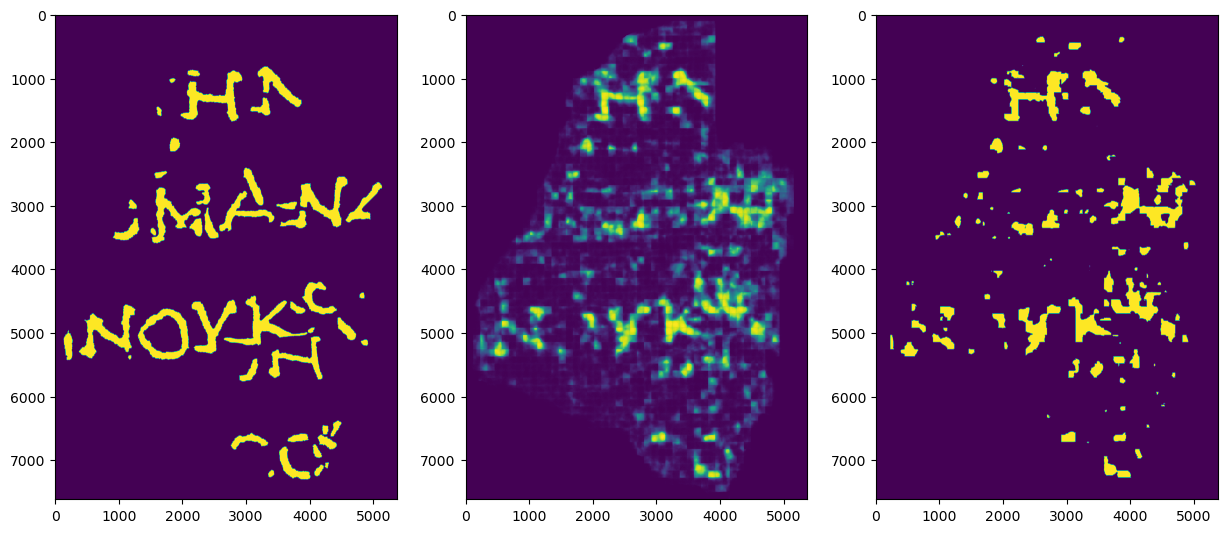

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([29738538.,  3101754.,  1649654.,  1047209.,   774545.,   627602.,
          497917.,   418671.,   365736.,   315715.,   284752.,   260675.,
          237869.,   220809.,   198501.,   215160.,   228933.,   243253.,
          307959.,   208364.]),
 array([1.20525807e-05, 4.95057485e-02, 9.89994444e-02, 1.48493140e-01,
        1.97986836e-01, 2.47480532e-01, 2.96974228e-01, 3.46467924e-01,
        3.95961620e-01, 4.45455316e-01, 4.94949012e-01, 5.44442708e-01,
        5.93936404e-01, 6.43430100e-01, 6.92923795e-01, 7.42417491e-01,
        7.91911187e-01, 8.41404883e-01, 8.90898579e-01, 9.40392275e-01,
        9.89885971e-01]),
 <BarContainer object of 20 artists>)

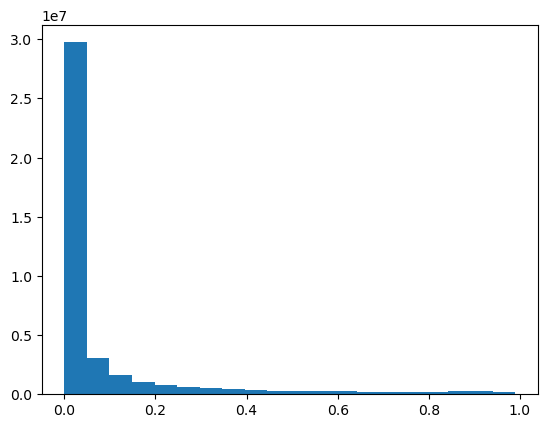

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000